## Description

In this lab, you will learn how to fine-tune the LLaMA 3.2 3B model using two distinct methods: Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO). The lab is structured to provide you with hands-on experience in adapting a large language model to specific tasks by:

1. Setting up the environment and preparing the necessary tools and libraries.
2. Loading the pre-trained LLaMA 3.2 3B model.
3. Performing supervised fine-tuning (SFT) to adapt the model to a dataset.
4. Applying Direct Preference Optimization (DPO) to further refine the model's behavior based on preference annotations.
5. Evaluating and comparing the performance of the two fine-tuned models on a shared task.

You will explore the fundamental steps required for fine-tuning large language models while understanding the differences between SFT and DPO approaches. Additionally, the lab introduces evaluation strategies to measure and compare model performance.

While this notebook guides you through the essential steps, additional tasks are provided as exercises for deeper exploration and application of the learned concepts.

This [notebook](https://www.kaggle.com/code/danielhanchen/kaggle-llama-3-2-1b-3b-conversational-unsloth) was used as a basis for the current work.

## Step 1: Install Required Libraries

To begin, we need to set up the environment by installing all necessary libraries and dependencies. This ensures that we have the appropriate versions of PyTorch, transformers, and other tools required for fine-tuning the LLaMA model.

In [1]:
!pip install pip3-autoremove

!pip-autoremove torch torchvision torchaudio -y

!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121

!pip install unsloth

# dependency conflicts
# tensorflow-metadata, ydf, grpcio-status need newer protobuf
# ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1
!pip install "protobuf>=5.29.1,<6.0.0" --upgrade
!pip install "fsspec==2025.3.2" --upgrade

!pip install evaluate

!pip install accelerate --upgrade

fsspec 2025.3.0 is installed but fsspec==2025.3.2 is required
Redoing requirement with just package name...
The 'jedi>=0.16' distribution was not found and is required by the application
Skipping jedi
protobuf 5.29.4 is installed but protobuf<4.0.0 is required
Redoing requirement with just package name...
protobuf 5.29.4 is installed but protobuf<4.0.0 is required
Redoing requirement with just package name...
torchvision 0.20.1+cu121 (/usr/local/lib/python3.11/dist-packages)
    torch 2.5.1+cu121 (/usr/local/lib/python3.11/dist-packages)
        nvidia-cuda-nvrtc-cu12 12.1.105 (/usr/local/lib/python3.11/dist-packages)
        nvidia-cuda-runtime-cu12 12.1.105 (/usr/local/lib/python3.11/dist-packages)
        nvidia-cuda-cupti-cu12 12.1.105 (/usr/local/lib/python3.11/dist-packages)
        nvidia-cudnn-cu12 9.1.0.70 (/usr/local/lib/python3.11/dist-packages)
        nvidia-nvtx-cu12 12.1.105 (/usr/local/lib/python3.11/dist-packages)
        sympy 1.13.1 (/usr/local/lib/python3.11/dist-pa

  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.5.7 requires protobuf<4.0.0, but you have protobuf 5.29.4 which is incompatible.
unsloth 2025.5.6 requires protobuf<4.0.0, but you have protobuf 5.29.4 which is incompatible.
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resol

## Step 2: Load the Pre-trained LLaMA Model

In this step, we will load the pre-trained LLaMA 3.2 3B model using the `FastLanguageModel` utility from the `unsloth` library. This utility simplifies model loading and supports advanced features like RoPE scaling and 4-bit quantization for memory efficiency.

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

base_model_name = "unsloth/Llama-3.2-3B-Instruct"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Step 3: Prepare the Parameter-Efficient Fine-Tuning (PEFT)

In this section, we will prepare the pre-trained LLaMA model for fine-tuning using Parameter-Efficient Fine-Tuning (PEFT). PEFT allows us to adapt large language models to new tasks by fine-tuning only a small subset of their parameters, significantly reducing computational and memory requirements.

We will leverage the `get_peft_model` function from the `unsloth` library to apply LoRA (Low-Rank Adaptation) fine-tuning, a popular PEFT technique. This involves injecting lightweight, learnable adapters into specific layers of the model. The parameters of the main model remain frozen, making this method both efficient and scalable.

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
)

Unsloth 2025.5.6 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## Step 4: Data Preparation for Supervised Fine-tuning (SFT)
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

The `get_chat_template` function is used to get the correct chat template.

In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [5]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

We look at how the conversations are structured for an item, e.g., 12:

In [6]:
dataset[12]["conversations"]

[{'content': 'Write Python code to solve the task:\nIn programming, hexadecimal notation is often used.\n\nIn hexadecimal notation, besides the ten digits 0, 1, ..., 9, the six letters `A`, `B`, `C`, `D`, `E` and `F` are used to represent the values 10, 11, 12, 13, 14 and 15, respectively.\n\nIn this problem, you are given two letters X and Y. Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nWhen X and Y are seen as hexadecimal numbers, which is larger?\n\nConstraints\n\n* Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nInput\n\nInput is given from Standard Input in the following format:\n\n\nX Y\n\n\nOutput\n\nIf X is smaller, print `<`; if Y is smaller, print `>`; if they are equal, print `=`.\n\nExamples\n\nInput\n\nA B\n\n\nOutput\n\n<\n\n\nInput\n\nE C\n\n\nOutput\n\n>\n\n\nInput\n\nF F\n\n\nOutput\n\n=',
  'role': 'user'},
 {'content': "Step 1:  The problem involves comparing two letters in hexadecimal notation.\nStep 2:  We need to convert the letters X and Y to decimal num

And we see how the chat template transformed these conversations.

In [7]:
dataset[12]["text"]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWrite Python code to solve the task:\nIn programming, hexadecimal notation is often used.\n\nIn hexadecimal notation, besides the ten digits 0, 1, ..., 9, the six letters `A`, `B`, `C`, `D`, `E` and `F` are used to represent the values 10, 11, 12, 13, 14 and 15, respectively.\n\nIn this problem, you are given two letters X and Y. Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nWhen X and Y are seen as hexadecimal numbers, which is larger?\n\nConstraints\n\n* Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nInput\n\nInput is given from Standard Input in the following format:\n\n\nX Y\n\n\nOutput\n\nIf X is smaller, print `<`; if Y is smaller, print `>`; if they are equal, print `=`.\n\nExamples\n\nInput\n\nA B\n\n\nOutput\n\n<\n\n\nInput\n\nE C\n\n\nOutput\n\n>\n\n\nInput\n\nF F\n\n\nOutput\n\n=<|eot

We split the dataset to training and validation set:

In [8]:
train_dataset = dataset.select(range(0, int(0.8 * len(dataset))))  # 80% for training
eval_dataset = dataset.select(range(int(0.8 * len(dataset)), len(dataset)))  # 20% for evaluation

## Step 5: Fine-tune the model with SFT
We will use Huggingface TRL's `SFTTrainer`. More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 100 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 21,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [10]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

We verify masking is actually done:

In [11]:
tokenizer.decode(trainer.train_dataset[12]["input_ids"])

"<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWrite Python code to solve the task:\nIn programming, hexadecimal notation is often used.\n\nIn hexadecimal notation, besides the ten digits 0, 1,..., 9, the six letters `A`, `B`, `C`, `D`, `E` and `F` are used to represent the values 10, 11, 12, 13, 14 and 15, respectively.\n\nIn this problem, you are given two letters X and Y. Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nWhen X and Y are seen as hexadecimal numbers, which is larger?\n\nConstraints\n\n* Each X and Y is `A`, `B`, `C`, `D`, `E` or `F`.\n\nInput\n\nInput is given from Standard Input in the following format:\n\n\nX Y\n\n\nOutput\n\nIf X is smaller, print `<`; if Y is smaller, print `>`; if they are equal, print `=`.\n\nExamples\n\nInput\n\nA B\n\n\nOutput\n\n<\n\n\nInput\n\nE C\n\n\nOutput\n\n>\n\n\nInput\n\nF F\n\n\n

In [12]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[12]["labels"]])

"                                                                                                                                                                                                                                                                            Step 1:  The problem involves comparing two letters in hexadecimal notation.\nStep 2:  We need to convert the letters X and Y to decimal numbers and then compare them to determine which is larger.\nStep 3:  We can define a function to convert a letter to its decimal equivalent, and then use this function to compare X and Y.\nStep 4:  Based on the comparison, we will print '<', '>', or '=' to indicate which letter is larger or if they are equal.\n```python\n# Step 5:  Define a function to compare two letters X and Y when they are seen as hexadecimal numbers.\ndef compare_hex_letters(X, Y):\n    # Step 6:  Convert the letters X and Y to decimal numbers using the ord function.\n    \n    a = ord(X)\n    b = ord(Y)\n    # Ste

We can see the System and Instruction prompts are successfully masked.

In [13]:
# Report current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
3.441 GB of memory reserved.


### Step 5a: Training Progress Monitoring, Checkpoint Management and Early Stopping

Before calling `trainer.train()` we define a custom callback to (i) **log metrics** during the training and (ii) manage how we save checkpoints at regular intervals and (iii) implement **early stopping** using the validation set:

In [14]:
import csv
import os
import shutil
from transformers import TrainerCallback

# Define a custom callback
class MetricsLoggerEvalCallback(TrainerCallback):
    def __init__(self, log_file, trainer, eval_log_step=10, max_eval_steps=5, patience=3, max_checkpoints=2):
        super().__init__()
        self.log_file = log_file
        self.trainer = trainer
        self.eval_log_step = eval_log_step
        self.max_eval_steps = max_eval_steps
        self.patience = patience
        self.max_checkpoints = max_checkpoints
        self.best_val_loss = float("inf")
        self.no_improve_counter = 0
        self.saved_checkpoints = []
        self.checkpoint_dir = os.path.join("outputs", "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Prepare CSV for logging
        with open(self.log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Step", "Training Loss", "Validation Loss", "Learning Rate", "Memory Usage"])

    def limited_evaluate(self):
        """
        Perform a limited evaluation and return only the validation loss.
        """
        eval_dataloader = self.trainer.get_eval_dataloader()
        total_loss = 0.0
        num_batches = 0

        for step, batch in enumerate(eval_dataloader):
            if step >= self.max_eval_steps:
                break

            # Perform a prediction step
            outputs = trainer.prediction_step(
                trainer.model, batch, prediction_loss_only=True
            )

            # Extract the loss (first item in outputs)
            loss = outputs[0]
            total_loss += loss.item()  # Convert loss tensor to float
            num_batches += 1

        # Compute average validation loss
        avg_val_loss = total_loss / num_batches if num_batches > 0 else float("inf")
        return avg_val_loss

    def on_step_end(self, args, state, control, logs=None, **kwargs):
        step = state.global_step
        if step % self.eval_log_step == 0:
            logs = logs or {}
            training_loss = logs.get("loss") or (state.log_history[-1].get("loss") if state.log_history else None)
            learning_rate = logs.get("learning_rate") or self.trainer.lr_scheduler.get_last_lr()[0]
            memory_usage = round(torch.cuda.memory_reserved() / 1024 / 1024 / 1024, 3)
            val_loss = self.limited_evaluate()

            # Log to console
            print(f"Step {step}: Loss={training_loss}, Validation Loss={val_loss}, LR={learning_rate}, Memory={memory_usage} GB")

            # Save to CSV
            with open(self.log_file, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([step, training_loss, val_loss, learning_rate, memory_usage])

            # Save checkpoint if validation loss improves
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.no_improve_counter = 0
                checkpoint_path = os.path.join(self.checkpoint_dir, f"checkpoint-step-{step}")
                self.trainer.save_model(checkpoint_path)
                print(f"Saved checkpoint at {checkpoint_path}")

                # Manage checkpoint storage
                self.saved_checkpoints.append(checkpoint_path)
                if len(self.saved_checkpoints) > self.max_checkpoints:
                    old_checkpoint = self.saved_checkpoints.pop(0)
                    shutil.rmtree(old_checkpoint)
                    print(f"Deleted old checkpoint: {old_checkpoint}")
            else:
                self.no_improve_counter += 1
                print(f"No improvement in validation loss for {self.no_improve_counter} evaluations.")

            # Early stopping
            if self.no_improve_counter >= self.patience:
                print("Early stopping triggered. Training terminated.")
                control.should_training_stop = True

# Initialize callback
log_file = "outputs/training_metrics.csv"
metrics_logger_evaluator = MetricsLoggerEvalCallback(log_file=log_file, trainer=trainer, eval_log_step=10, max_eval_steps=5)

In [15]:
trainer.add_callback(metrics_logger_evaluator)

# Run training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.815600
2,1.061100
3,1.086100
4,0.881000
5,0.703400
6,1.103700
7,0.814800
8,0.954500
9,0.857100
10,0.698900


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step 10: Loss=0.8571, Validation Loss=0.8045812964439392, LR=0.00018947368421052632, Memory=3.422 GB
Saved checkpoint at outputs/checkpoints/checkpoint-step-10
Step 20: Loss=0.5061, Validation Loss=0.7816206455230713, LR=0.00016842105263157895, Memory=3.969 GB
Saved checkpoint at outputs/checkpoints/checkpoint-step-20
Step 30: Loss=0.8011, Validation Loss=0.7719449877738953, LR=0.00014736842105263158, Memory=3.969 GB
Saved checkpoint at outputs/checkpoints/checkpoint-step-30
Deleted old checkpoint: outputs/checkpoints/checkpoint-step-10
Step 40: Loss=0.7419, Validation Loss=0.7661083936691284, LR=0.0001263157894736842, Memory=3.971 GB
Saved checkpoint at outputs/checkpoints/checkpoint-step-40
Deleted old checkpoint: outputs/checkpoints/checkpoint-step-20
Step 50: Loss=0.9458, Validation Loss=0.7625956773757935, LR=0.00010526315789473685, Memory=3.971 GB
Saved checkpoint at outputs/checkpoints/checkpoint-step-50
Deleted old checkpoint: outputs/checkpoints/checkpoint-step-30
Step 60: Los

In [16]:
# Report final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

430.5812 seconds used for training.
7.18 minutes used for training.
Peak reserved memory = 4.07 GB.
Peak reserved memory for training = 0.629 GB.
Peak reserved memory % of max memory = 18.366 %.
Peak reserved memory for training % of max memory = 2.838 %.


### Step 5b: Plot key metrics during SFT

We need to plot Training Loss, Validation Loss, Learning Rate and Memory Usage.



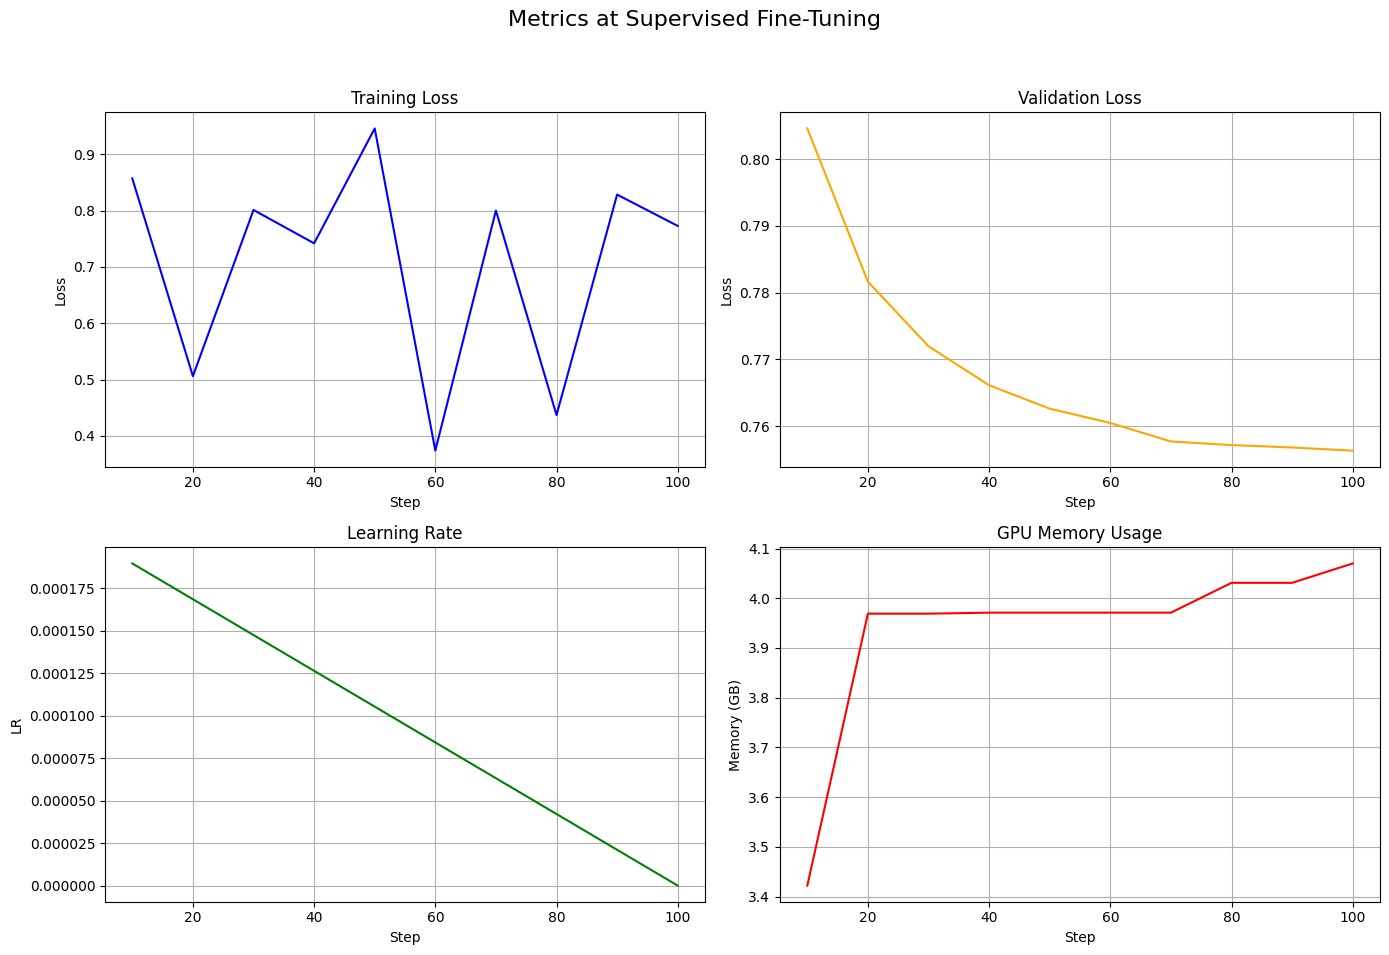

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("outputs/training_metrics.csv")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Metrics at Supervised Fine-Tuning", fontsize = 16)

# Training Loss
axs[0, 0].plot(df["Step"], df["Training Loss"], label="Training Loss", color="blue")
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

# Validation Loss
axs[0, 1].plot(df["Step"], df["Validation Loss"], label="Validation Loss", color="orange")
axs[0, 1].set_title("Validation Loss")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True)

# Learning Rate
axs[1, 0].plot(df["Step"], df["Learning Rate"], label="Learning Rate", color="green")
axs[1, 0].set_title("Learning Rate")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("LR")
axs[1, 0].grid(True)

# Memory Usage
axs[1, 1].plot(df["Step"], df["Memory Usage"], label="Memory (GB)", color="red")
axs[1, 1].set_title("GPU Memory Usage")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Memory (GB)")
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Step 6: Run inference on the fine-tuned model
Let's run the model. You can specify the instruction.

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [18]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nSure, here is a continuation of the Fibonacci sequence starting from where it was left off:\n\n1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144\n\nThe Fibonacci sequence is a series of numbers in which each']

You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time.

In [19]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding numbers, starting from 1 and 1. Therefore, after 8, the next numbers in the sequence would be 13 and 21.

So, the continued Fibonacci sequence would be: 1, 1, 2, 3, 5, 8, 13, 21.<|eot_id|>


## Step 7: Generate Responses Using a Helper Function
Now, we will define a helper function to make the model generate responses based on a given instruction. This function simplifies the inference process and can be used to test the model's behavior after fine-tuning.

In [20]:
def generate_response(instruction, model, tokenizer, max_new_tokens=128):

    messages = [
        {"role": "user", "content": instruction},
    ]

    # Tokenize the input instruction
    inputs = tokenizer(instruction, return_tensors="pt").to(model.device)

    # Generate response using the model
    outputs = model.generate(
        # Dictionary unpacking
        **inputs,
        max_new_tokens = max_new_tokens,
        do_sample = True,
        # Τemperature ψontrols the randomness of the sampling process
        # by scaling the logits before applying softmax
        temperature = 0.7,
        top_p = 0.9
    )

    # Decode and return the response
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [21]:
# Example usage
instruction = "Explain the significance of LoRA in fine-tuning large language models."
response = generate_response(instruction, model, tokenizer, max_new_tokens=512)
print(f"Instruction: {instruction}\nResponse: {response}")

Instruction: Explain the significance of LoRA in fine-tuning large language models.
Response: Explain the significance of LoRA in fine-tuning large language models. 
### Step 1: Understand the concept of LoRA
LoRA (Layer-wise Regularization) is a technique used to fine-tune large language models by selectively pruning layers and updating the remaining layers. This technique helps in reducing the computational cost and memory requirements of the model.

### Step 2: Explain the significance of LoRA in fine-tuning large language models
LoRA is significant because it allows for more efficient and cost-effective fine-tuning of large language models. By selectively pruning layers, LoRA reduces the computational cost and memory requirements of the model, making it more feasible to fine-tune large models on smaller datasets. Additionally, LoRA helps in reducing the overfitting of the model by pruning layers that are not contributing significantly to the model's performance. This results in a m

## Step 8: Saving, loading fine-tuned models
To save the final model as LoRA adapters, we use `save_pretrained` for a local save.

**Note** that this ONLY saves the LoRA adapters, and not the full model.

In [22]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Load the model we just saved:

In [23]:
sft_model, sft_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(sft_model) # Enable native 2x faster inference

# run inference
instruction = "Describe a tall tower in the capital of France."
response = generate_response(instruction, sft_model, sft_tokenizer, max_new_tokens=512)
print(f"Instruction: {instruction}\nResponse: {response}")

==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Instruction: Describe a tall tower in the capital of France.
Response: Describe a tall tower in the capital of France. The tower is known for its unique architecture and is considered a symbol of the country's rich history and culture. The tower is built on a small island in the city, and its walls are covered in ivy, with windows that reflect the colors of the rainbow. The tower is surrounded by a beautiful garden filled with vibrant flowers and the soothing sounds of a small fountain.

The tower stands at an impressive height of 50 mete

## Step 9: Evaluate Models using OpenAssistant Conversations Dataset

To evaluate the performance of the base model and LoRA-adapted model, we will use the [OpenAssistant Conversations Dataset](https://huggingface.co/datasets/OpenAssistant/oasst1). This dataset provides instruction-response pairs in a conversational format, allowing us to test the model's ability to follow instructions and generate coherent, contextually relevant responses.

### Prepare the evaluation dataset
The dataset uses the roles `prompter` and `assistant`. Prompter messages (role: "prompter") can be considered instructions, and assistant messages (role: "assistant") as corresponding responses.

We construct input-output pairs by traversing the message tree (`parent_id` field) and linking each prompter message to its next assistant message. We will use a part of the dataset, e.g., 100 samples.

In [24]:
dataset = load_dataset("OpenAssistant/oasst1", split="validation")

# Extract input-output pairs
def extract_pairs(dataset, n_samples=100):
    pairs = []
    for sample in dataset:
        if sample["lang"] != "en":
            continue
        if sample["role"] == "prompter":
            # Find the child message with 'assistant' role
            child_message = next(
                (item for item in dataset if item["parent_id"] == sample["message_id"] and item["role"] == "assistant"),
                None
            )
            if child_message:
                pairs.append({
                    "instruction": sample["text"],
                    "response": child_message["text"]
                })
        if len(pairs) == n_samples:
            break
    return pairs

input_output_pairs = extract_pairs(dataset)

# Inspect extracted pairs
print(f"Extracted {len(input_output_pairs)} input-output pairs.")
print(input_output_pairs[:3])

Extracted 100 input-output pairs.
[{'instruction': 'What do you think about ChatGPT?', 'response': "As an open source alternative to ChatGPT, I do not have personal opinions. However, I can provide objective information about ChatGPT's capabilities and limitations based on its architecture and training data.\n\nChatGPT is a powerful language model based on the GPT (Generative Pre-trained Transformer) architecture developed by OpenAI. It has been trained on a large corpus of text data and is capable of generating human-like responses to a wide variety of prompts and questions. ChatGPT's ability to generate coherent and contextually relevant responses is based on its ability to understand the structure of language and make predictions about what words and phrases are likely to follow in a given context.\n\nHowever, like all language models, ChatGPT has limitations. Its responses are based solely on the patterns it has learned from its training data and it may generate responses that are 

### Helper function for getting model results

In [25]:
from tqdm import tqdm
def get_model_results(model, tokenizer, pairs):

    results = []
    for pair in tqdm(pairs):
        # Extract the user instruction from the pair
        instruction = pair["instruction"]
        # Extract the ground truth response
        reference = pair["response"]
        prediction = generate_response(instruction, model, tokenizer)

        results.append({
            "instruction": instruction,
            "reference": reference,
            "prediction": prediction
        })
    return results

### Get the results of both pre-trained (base) and SFT models

In [26]:
# load base model for inference
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(base_model)

==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,)

In [27]:
# Get the results of both models
base_model_results = get_model_results(base_model, tokenizer, input_output_pairs)
sft_model_results = get_model_results(sft_model, tokenizer, input_output_pairs)

100%|██████████| 100/100 [11:06<00:00,  6.66s/it]


### Apply Evaluation Metrics

We can now compute metrics like BLEU, ROUGE, or BERTScore using the reference and prediction fields.

In [28]:
import evaluate

def evaluate_model_results(model_results, metric_name):

    metric = evaluate.load(metric_name)
    references = [result["reference"] for result in model_results] # Ground-truth responses
    predictions = [result["prediction"] for result in model_results] # Model responses

    # Compute the metric
    if metric_name == "bertscore":
      evaluation = metric.compute(predictions=predictions,
                                  references=[[ref] for ref in references],
                                  lang="en")  # Specify the language for BERTScore
    else:
      evaluation = metric.compute(predictions=predictions,
                                  references=[[ref] for ref in references])

    return evaluation

In [29]:
!pip install rouge_score
!pip install bert-score

In [30]:
# Compare models using several evaluation metrics
import numpy as np
# Evaluate using BLEU
bleu_base = evaluate_model_results(base_model_results, "bleu")
bleu_finetuned = evaluate_model_results(sft_model_results, "bleu")
print(f"BLEU Score - Base Model: {bleu_base}")
print(f"BLEU Score - Fine-tuned Model: {bleu_finetuned}")

# Evaluate using ROUGE
rouge_base = evaluate_model_results(base_model_results, "rouge")
rouge_finetuned = evaluate_model_results(sft_model_results, "rouge")
print(f"ROUGE Score - Base Model: {rouge_base}")
print(f"ROUGE Score - Fine-tuned Model: {rouge_finetuned}")

# Evaluate using BERTScore
bertscore_base = evaluate_model_results(base_model_results, "bertscore")
bertscore_finetuned = evaluate_model_results(sft_model_results, "bertscore")
print("BERTScore - Base Model:")
print(f"  Precision: {np.mean(bertscore_base['precision']):.4f}")
print(f"  Recall:    {np.mean(bertscore_base['recall']):.4f}")
print(f"  F1 Score:  {np.mean(bertscore_base['f1']):.4f}")

print("BERTScore - Fine-tuned Model:")
print(f"  Precision: {np.mean(bertscore_finetuned['precision']):.4f}")
print(f"  Recall:    {np.mean(bertscore_finetuned['recall']):.4f}")
print(f"  F1 Score:  {np.mean(bertscore_finetuned['f1']):.4f}")

BLEU Score - Base Model: {'bleu': 0.06380060048774792, 'precisions': [0.33880813038827007, 0.10081692103096701, 0.0484991396341852, 0.02822140978769803], 'brevity_penalty': 0.7715689961234542, 'length_ratio': 0.7940735558664801, 'translation_length': 15891, 'reference_length': 20012}
BLEU Score - Fine-tuned Model: {'bleu': 0.06920717246816778, 'precisions': [0.34525837592277114, 0.11061019747285541, 0.0537414531279954, 0.0319634703196347], 'brevity_penalty': 0.7689983814041056, 'length_ratio': 0.7919748151109335, 'translation_length': 15849, 'reference_length': 20012}
ROUGE Score - Base Model: {'rouge1': np.float64(0.28232659063091153), 'rouge2': np.float64(0.0828013115691005), 'rougeL': np.float64(0.16161558794097278), 'rougeLsum': np.float64(0.23634777100470755)}
ROUGE Score - Fine-tuned Model: {'rouge1': np.float64(0.27952943242356876), 'rouge2': np.float64(0.08209215956237667), 'rougeL': np.float64(0.16289714529005545), 'rougeLsum': np.float64(0.2340918944057058)}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore - Base Model:
  Precision: 0.8397
  Recall:    0.8384
  F1 Score:  0.8388
BERTScore - Fine-tuned Model:
  Precision: 0.8415
  Recall:    0.8374
  F1 Score:  0.8392


## Step 10: Fine-tune the base model using DPO


In [31]:
# Report current memory stats
import torch
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
11.281 GB of memory reserved.


In [32]:
import torch
from datasets import load_dataset
from transformers import TrainingArguments
from trl import DPOTrainer
from unsloth import FastLanguageModel, is_bfloat16_supported
from peft import PeftModel
import traceback

# Copied Step 2 and Step 3 from SFT Training
# ------------------------------------------
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

base_model_name = "unsloth/Llama-3.2-3B-Instruct"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    max_seq_length=max_seq_length,
)
# ------------------------------------------

# Sanity checks
print(f"Tokenizer: {tokenizer}")
print(f"Tokenizer pad_token: {tokenizer.pad_token}, pad_token_id: {tokenizer.pad_token_id}")
if tokenizer.pad_token is None:
    print("CRITICAL WARNING: tokenizer.pad_token is None.")
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model type: {type(model)}")

current_use_cache = None

# ------------------------------------------
dpo_dataset_full = load_dataset("Intel/orca_dpo_pairs", split = "train")
dpo_dataset_full = dpo_dataset_full.rename_column('question', 'prompt')


split_dataset = dpo_dataset_full.train_test_split(test_size = 0.1, seed = 42)
train_dpo_dataset = split_dataset["train"]
eval_dpo_dataset = split_dataset["test"]
# ------------------------------------------

# Copied Step 5 from SFT Training
# ------------------------------------------
print("Initializing DPOTrainer...")
training_args = TrainingArguments(
    # Basic setup
    output_dir = "outputs_dpo_debug",
    seed = 21,
    report_to = "none",
    remove_unused_columns = False,  # Important for DPOTrainer

    # Training control
    max_steps = 100,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 5,

    # Optimizer and scheduler
    learning_rate = 2e-4,
    weight_decay = 0.01,
    optim = "adamw_8bit",
    lr_scheduler_type = "linear",

    # Precision
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),

    # Evaluation & logging
    logging_steps = 1,
)

dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,
    tokenizer = tokenizer,
    train_dataset = train_dpo_dataset,
    eval_dataset = eval_dpo_dataset,
    args = training_args,
)
print("DPOTrainer initialized.")
# ------------------------------------------
# Initialize and add callback
# dpo_metrics_log_file = "outputs/dpo_training_metrics.csv"
# dpo_metrics_logger_evaluator = MetricsLoggerEvalCallback(log_file=dpo_metrics_log_file, trainer=dpo_trainer, eval_log_step=10, max_eval_steps=5)
# dpo_trainer.add_callback(dpo_metrics_logger_evaluator)
# ------------------------------------------
# Training
try:
    dpo_trainer_stats = dpo_trainer.train()
    print("DPO training finished.")
    if dpo_trainer_stats:
        print(dpo_trainer_stats)
except Exception as e:
    print(f"An error occurred during dpo_trainer.train():")
    traceback.print_exc()

==((====))==  Unsloth 2025.5.6: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Tokenizer: PreTrainedTokenizerFast(name_or_path='unsloth/llama-3.2-3b-instruct-unsloth-bnb-4bit', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '<|finetune_right_pad_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rst

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,573 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
1,0.693100,0.000000,0.000000,0.000000,0.000000,-153.422852,-208.524078,0.117732,0.178122,0,0,0,0
2,0.693100,0.000000,0.000000,0.000000,0.000000,-180.398056,-170.007004,-0.187644,0.135353,No Log,No Log,No Log,No Log
3,0.687100,0.012824,-0.000616,0.375000,0.013440,-111.177040,-166.111328,0.011036,0.343426,No Log,No Log,No Log,No Log
4,0.678400,0.003322,-0.026822,0.625000,0.030144,-150.158600,-186.937744,-0.037077,0.279276,No Log,No Log,No Log,No Log
5,0.674500,-0.012721,-0.051537,0.750000,0.038816,-127.877853,-162.482300,-0.071527,0.097120,No Log,No Log,No Log,No Log
6,0.610000,-0.018829,-0.199598,0.875000,0.180769,-237.268295,-211.266052,0.237227,0.499680,No Log,No Log,No Log,No Log
7,0.493500,-0.087766,-0.563288,1.000000,0.475523,-403.237427,-269.731934,0.123187,0.037804,No Log,No Log,No Log,No Log
8,0.397100,-0.213510,-0.984486,1.000000,0.770976,-251.754623,-241.050385,0.294447,-0.016132,No Log,No Log,No Log,No Log
9,0.254700,-0.111391,-1.528850,1.000000,1.417459,-68.688828,-153.924164,-0.536586,0.132734,No Log,No Log,No Log,No Log
10,0.172900,-0.497857,-2.547520,1.000000,2.049663,-343.761536,-300.357758,-0.377637,-0.414643,No Log,No Log,No Log,No Log


DPO training finished.
TrainOutput(global_step=100, training_loss=0.08371178271720207, metrics={'train_runtime': 587.0577, 'train_samples_per_second': 1.363, 'train_steps_per_second': 0.17, 'total_flos': 0.0, 'train_loss': 0.08371178271720207, 'epoch': 0.06912044237083118})


In [33]:
# Report final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{dpo_trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(dpo_trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

587.0577 seconds used for training.
9.78 minutes used for training.
Peak reserved memory = 16.885 GB.
Peak reserved memory for training = 5.604 GB.
Peak reserved memory % of max memory = 76.192 %.
Peak reserved memory for training % of max memory = 25.288 %.


## Step 11: Evaluate the - fine-tuned with DPO - model

Use the same evaluation dataset with the previous model and compare the three models (base, SFT, DPO) performance using various metrics.

## Step 12: Design Evaluation Prompts to perform Qualitative analysis

### Exercise Instructions:
1. **Design Evaluation Prompts**:
   - Create at least 7 distinct prompts that test various abilities, such as:
     - Instruction-following (e.g., "Explain the difference between LoRA and fine-tuning.")
     - Creativity (e.g., "Write a short story about a time-traveling musician.")
     - Factual accuracy (e.g., "What is the capital of Japan?")
     - Problem-solving (e.g., "Solve the equation: x + 5 = 10.")
   - Ensure a mix of simple and complex prompts.

2. **Generate Responses**:
   - Use the `generate_response()` function to get outputs from `base_model`, `sft_model`, and `dpo_model` for each prompt.

3. **Perform Qualitative Analysis**:
   - Compare the responses qualitatively across the models based on:
     - **Coherence**: Is the response logical and well-structured?
     - **Relevance**: Does it directly address the prompt?
     - **Fluency**: Is the response grammatically correct and readable?
     - **Accuracy**: For factual questions, is the information correct?
     - **Creativity**: For open-ended prompts, is the response engaging and original?

In [34]:
# Question 1: "Explain the difference between LoRA and fine-tuning."
# Question 2: "Write a short story about a time-traveling musician."
# Question 3: "What is the capital of Japan?"
# Question 4: "Solve the equation: x + 5 = 10."
# Question 5: "Translate the following English sentence into Spanish: “The school is painted red.”"
# Question 6: "If an animal barks, is it a dog or a cat? Explain your reasoning."
# Question 7: "Is the National Technical University of Athens well-established?"

questions = [
    "Explain the difference between LoRA and fine-tuning.",
    "Write a short story about a time-traveling musician.",
    "What is the capital of Japan?",
    "Solve the equation: x + 5 = 10.",
    "Translate the following English sentence into Spanish: “The school is painted red.”",
    "If an animal barks, is it a dog or a cat? Explain your reasoning.",
    "Is the National Technical University of Athens well-established?"
]

models = {
    "base": (base_model, base_tokenizer),
    "sft": (sft_model, sft_tokenizer)
}

# Loop through each question and each model
for i, question in enumerate(questions, 1):
    print(f"\n=== Question {i}: {question} ===")
    for model_name, (model, tokenizer) in models.items():
        response = generate_response(question, model, tokenizer, max_new_tokens=512)
        print(f"\nModel: {model_name}")
        print(f"Response:\n{response}")


=== Question 1: Explain the difference between LoRA and fine-tuning. ===

Model: base
Response:
Explain the difference between LoRA and fine-tuning. two AI models
LoRA and fine-tuning are two different approaches to improve the performance of AI models. While both methods aim to adapt models to specific tasks or datasets, they differ in their underlying architecture and the nature of the adaptations.

**LoRA (Low-Rank Adaptation)**

LoRA is a type of low-rank adaptation that modifies the weights of a pre-trained model to better fit a new task or dataset. The idea is to learn a low-rank matrix that represents the adaptation process, which is then applied to the original weights. This process can be viewed as a linear transformation of the weights.

LoRA works by:

1. Pre-training a model on a large dataset
2. Selecting a subset of the weights to be adapted
3. Learning a low-rank matrix (typically 2D) that represents the adaptation process
4. Applying the adaptation matrix to the select